In [1]:
# Minimal environment check (no pip installs)
import sys, tensorflow as tf, os
print("Python:", sys.version.splitlines()[0])
print("TensorFlow:", tf.__version__)
print("Available physical GPUs:", tf.config.list_physical_devices('GPU'))
# Show nvidia-smi if available (optional)
os.system("nvidia-smi || echo 'nvidia-smi not available in this runtime'")


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TensorFlow: 2.19.0
Available physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


0

In [2]:
from google.colab import files
files.upload()   # choose kaggle.json when prompt appears (do this step)


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ruthwikreddy1605","key":"5ccc8c17869616088ff3b1fb73ef95e0"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
# downloads the dataset into /content/ultrasound_project and unzips
!mkdir -p /content/ultrasound_project
%cd /content/ultrasound_project
!kaggle datasets download -d orvile/bus-uclm-breast-ultrasound-dataset -p /content/ultrasound_project --unzip
!ls -la


/content/ultrasound_project
Dataset URL: https://www.kaggle.com/datasets/orvile/bus-uclm-breast-ultrasound-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 95% 608M/642M [00:04<00:00, 114MB/s]
100% 642M/642M [00:06<00:00, 104MB/s]
total 16
drwxr-xr-x 4 root root 4096 Nov 22 13:55  .
drwxr-xr-x 1 root root 4096 Nov 22 13:54  ..
drwxr-xr-x 3 root root 4096 Nov 22 13:55 'BUS-UCLM Breast ultrasound lesion segmentation dataset'
drwxr-xr-x 5 root root 4096 Nov 22 13:55  bus_uclm_separated


In [5]:
import os
for root, dirs, files in os.walk("/content/ultrasound_project", topdown=True):
    level = root.replace("/content/ultrasound_project", "").count(os.sep)
    indent = " " * 2 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    if level==1:
        print("   subfolders:", dirs)
    if level>1:
        # limit printing files for brevity
        print(f"{indent}  {len(files)} files (showing up to 5):", files[:5])


ultrasound_project/
  bus_uclm_separated/
   subfolders: ['benign', 'malign', 'normal']
    benign/
      174 files (showing up to 5): ['PLBA_019.png', 'ALWI_002.png', 'ORPE_001.png', 'TOCI_020.png', 'HESN_005.png']
    malign/
      90 files (showing up to 5): ['FLBA_005.png', 'SIBA_003.png', 'CODE_006.png', 'CHVI_001.png', 'ELCO_006.png']
    normal/
      419 files (showing up to 5): ['UNCU_009.png', 'HESN_011.png', 'TOCI_019.png', 'ORPE_010.png', 'CHSP_001.png']
  BUS-UCLM Breast ultrasound lesion segmentation dataset/
   subfolders: ['BUS-UCLM Breast ultrasound lesion segmentation dataset']
    BUS-UCLM Breast ultrasound lesion segmentation dataset/
      0 files (showing up to 5): []
      BUS-UCLM/
        1 files (showing up to 5): ['INFO.csv']
        images/
          683 files (showing up to 5): ['FLBA_005.png', 'UNCU_009.png', 'HESN_011.png', 'TOCI_019.png', 'ORPE_010.png']
        masks/
          683 files (showing up to 5): ['FLBA_005.png', 'UNCU_009.png', 'HESN_011.png'

In [6]:
import os

print("Contents of /content:")
print(os.listdir("/content"))

print("\nContents of /content/ultrasound_project:")
print(os.listdir("/content/ultrasound_project"))


Contents of /content:
['.config', 'drive', 'ultrasound_project', 'sample_data']

Contents of /content/ultrasound_project:
['bus_uclm_separated', 'BUS-UCLM Breast ultrasound lesion segmentation dataset']


In [7]:
DATA_DIR = "/content/ultrasound_project/BUS"


In [8]:
import os

print("Folder 1 contents:")
print(os.listdir("/content/ultrasound_project/BUS-UCLM Breast ultrasound lesion segmentation dataset"))

print("\nFolder 2 contents:")
print(os.listdir("/content/ultrasound_project/bus_uclm_separated"))


Folder 1 contents:
['BUS-UCLM Breast ultrasound lesion segmentation dataset']

Folder 2 contents:
['benign', 'malign', 'normal']


In [9]:
# ===== REPLACE previous dataset cell with this one =====
import tensorflow as tf, os, random, numpy as np
from glob import glob
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 224
BATCH_SIZE = 32

DATA_DIR = "/content/ultrasound_project/bus_uclm_separated"  # your folder

# allowed image extensions (filter out non-image files)
IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tiff", ".tif")

classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print("Classes:", classes)

# collect file paths and labels
file_paths = []
labels = []
for idx, cls in enumerate(classes):
    folder = os.path.join(DATA_DIR, cls)
    all_files = sorted(os.listdir(folder))
    # build only valid image files
    for fn in all_files:
        if fn.lower().endswith(IMG_EXTS):
            file_paths.append(os.path.join(folder, fn))
            labels.append(idx)

print(f"Found {len(file_paths)} image files across {len(classes)} classes.")

# shuffle together (deterministic seed)
data = list(zip(file_paths, labels))
random.Random(42).shuffle(data)
file_paths, labels = zip(*data)
file_paths = list(file_paths)
labels = list(labels)

# train/val/test split indices
n = len(file_paths)
train_end = int(0.8 * n)
val_end = int(0.9 * n)

train_files = file_paths[:train_end]
train_labels = labels[:train_end]
val_files = file_paths[train_end:val_end]
val_labels = labels[train_end:val_end]
test_files = file_paths[val_end:]
test_labels = labels[val_end:]

print("Split sizes -> train:", len(train_files), "val:", len(val_files), "test:", len(test_files))

# helper preprocess
def preprocess_image(path):
    # path is a tf.string scalar path
    image_bytes = tf.io.read_file(path)
    # use decode_image which handles png/jpg and returns rank-3 tensor [H,W,C]
    image = tf.io.decode_image(image_bytes, channels=1, expand_animations=False)
    image = tf.image.convert_image_dtype(image, tf.float32)  # 0..1
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.image.grayscale_to_rgb(image)  # make 3 channels
    return image

def make_ds(file_list, label_list, batch_size=BATCH_SIZE, shuffle=True):
    files_tf = tf.constant(file_list)
    labels_tf = tf.constant(label_list, dtype=tf.int32)
    ds = tf.data.Dataset.from_tensor_slices((files_tf, labels_tf))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(file_list), seed=42)
    def map_fn(path, label):
        img = preprocess_image(path)
        label_onehot = tf.one_hot(label, depth=len(classes))
        return img, label_onehot
    ds = ds.map(map_fn, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_files, train_labels)
val_ds   = make_ds(val_files, val_labels, shuffle=False)
test_ds  = make_ds(test_files, test_labels, shuffle=False)

# quick sanity check: show one sample shape and a small batch shape
for imgs, labs in train_ds.take(1):
    print("Batch images shape:", imgs.shape)
    print("Batch labels shape:", labs.shape)
    # show one image stats
    print("Sample image min/max:", tf.reduce_min(imgs[0]).numpy(), tf.reduce_max(imgs[0]).numpy())

print("Datasets ready: train_ds, val_ds, test_ds")


Classes: ['benign', 'malign', 'normal']
Found 683 image files across 3 classes.
Split sizes -> train: 546 val: 68 test: 69
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32, 3)
Sample image min/max: 0.024691427 0.9871005
Datasets ready: train_ds, val_ds, test_ds


In [10]:
# Cell A: GPU check, mixed precision, imports
import tensorflow as tf, os, math
from tensorflow import keras
from tensorflow.keras import layers
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

# Enable mixed precision for speed on GPU
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled (policy):", mixed_precision.global_policy())
except Exception as e:
    print("Mixed precision not enabled:", e)

# Useful globals (should match dataset)
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = len(classes)  # uses classes from your dataset cell
PAPER_PATH = "/mnt/data/952 Manuscript (1).pdf"   # your uploaded manuscript
print("Classes:", classes)
print("PAPER_PATH:", PAPER_PATH)


TF version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision enabled (policy): <DTypePolicy "mixed_float16">
Classes: ['benign', 'malign', 'normal']
PAPER_PATH: /mnt/data/952 Manuscript (1).pdf


In [11]:
# Cell B: Build hybrid model (Transformer encoder + RNN fusion)
from tensorflow.keras import Model, Input

def build_hybrid_model(img_size=IMG_SIZE, patch_size=16, embed_dim=128, num_heads=4,
                       mlp_dim=256, transformer_blocks=3, rnn_units=256, num_classes=NUM_CLASSES):
    # Input
    inp = Input(shape=(img_size, img_size, 3), name="image_input")
    # Patch embedding via Conv2D
    x = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding='valid', name="patch_conv")(inp)
    x = layers.Reshape((-1, embed_dim), name="patch_reshape")(x)  # (patches, embed_dim)

    # Transformer encoder stack
    for i in range(transformer_blocks):
        # Layer norm + MHA + residual
        y = layers.LayerNormalization(epsilon=1e-6, name=f"ln1_{i}")(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name=f"mha_{i}")(y, y)
        x = layers.Add(name=f"res1_{i}")([x, attn])
        # MLP block
        z = layers.LayerNormalization(epsilon=1e-6, name=f"ln2_{i}")(x)
        z = layers.Dense(mlp_dim, activation='gelu', name=f"mlp1_{i}")(z)
        z = layers.Dropout(0.1, name=f"drop_{i}")(z)
        z = layers.Dense(embed_dim, name=f"mlp2_{i}")(z)
        x = layers.Add(name=f"res2_{i}")([x, z])

    # Global context per image (C_t)
    C_t = layers.GlobalAveragePooling1D(name="global_pool")(x)   # shape (embed_dim,)

    # Project context to rnn space
    projC = layers.Dense(rnn_units, name="projectC")(C_t)        # (rnn_units,)
    # Make a single-step sequence for GRU
    H_in = layers.Reshape((1, rnn_units), name="rnn_input")(projC)
    H_t = layers.GRU(rnn_units, return_sequences=False, name="gru")(H_in)  # (rnn_units,)

    # Learnable scalar alpha: use a dense->sigmoid to get a scalar per batch
    alpha_raw = layers.Dense(1, activation='sigmoid', name="fusion_alpha_dense")(layers.Concatenate()([H_t, projC]))
    alpha = layers.Flatten(name="fusion_alpha")(alpha_raw)  # shape (batch,)

    # Fuse: F_t = alpha * H_t + (1-alpha) * projC
    # Expand alpha to match dims
    alpha_exp = layers.Lambda(lambda z: tf.expand_dims(z, axis=-1), name="alpha_expand")(alpha)
    F_t = layers.Lambda(lambda z: z[0]*z[1] + (1.0 - z[0])*z[2], name="fusion")([alpha_exp, H_t, projC])

    # Classification head
    out = layers.LayerNormalization(name="head_ln")(F_t)
    out = layers.Dense(256, activation='relu', name="head_fc1")(out)
    out = layers.Dropout(0.25)(out)
    # If using mixed_precision, final logits should be float32 for numeric stability
    out = layers.Dense(num_classes, name="logits")(out)
    out = layers.Activation('softmax', dtype='float32', name="softmax_out")(out)

    model = Model(inputs=inp, outputs=out, name="HybridTransRNN")
    return model

# Build and compile
model = build_hybrid_model()
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
# If mixed precision is used, wrap optimizer for loss scaling automatically by Keras
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "HybridTransRNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_conv (Conv2D) │ (None, 14, 14,    │     98,432 │ image_input[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_reshape       │ (None, 196, 128)  │          0 │ patch_conv[0][0]  │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln1_0               │ (None, 196, 128)  │        256 │ patch_reshape[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_0               │ (None, 196, 128)  │    263,808 │ ln1_0[0][0],      │
│ (MultiHeadAttentio… │                   │            │ ln1_0[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_0 (Add)        │ (None, 196, 128)  │          0 │ patch_reshape[0]… │
│                     │                   │            │ mha_0[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln2_0               │ (None, 196, 128)  │        256 │ res1_0[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp1_0 (Dense)      │ (None, 196, 256)  │     33,024 │ ln2_0[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_0 (Dropout)    │ (None, 196, 256)  │          0 │ mlp1_0[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp2_0 (Dense)      │ (None, 196, 128)  │     32,896 │ drop_0[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_0 (Add)        │ (None, 196, 128)  │          0 │ res1_0[0][0],     │
│                     │                   │            │ mlp2_0[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln1_1               │ (None, 196, 128)  │        256 │ res2_0[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_1               │ (None, 196, 128)  │    263,808 │ ln1_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ ln1_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_1 (Add)        │ (None, 196, 128)  │          0 │ res2_0[0][0],     │
│                     │                   │            │ mha_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln2_1               │ (None, 196, 128)  │        256 │ res1_1[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp1_1 (Dense)      │ (None, 196, 256)  │     33,024 │ ln2_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_1 (Dropout)    │ (None, 196, 256)  │          0 │ mlp1_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp2_1 (Dense)      │ (None, 196, 128)  │     32,896 │ drop_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_1 (Add)        │ (None, 196, 128)  │          0 │ res1_1[0][0],   

 Total params: 1,584,516 (6.04 MB)

 Trainable params: 1,584,516 (6.04 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras import layers, Model, optimizers

def patch_embed_model(input_shape=(IMG_SIZE,IMG_SIZE,3), patch_size=16, embed_dim=64):
    inp = layers.Input(shape=input_shape)
    # conv with stride=patch_size to get patch embeddings
    x = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inp)
    x = layers.Reshape((-1, embed_dim))(x)  # (patches, embed_dim)
    return Model(inp, x, name="patcher")

def transformer_block(seq_in, embed_dim=64, num_heads=4, mlp_dim=128):
    x1 = layers.LayerNormalization()(seq_in)
    att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x1, x1)
    x2 = layers.Add()([seq_in, att])
    y = layers.LayerNormalization()(x2)
    y = layers.Dense(mlp_dim, activation='gelu')(y)
    y = layers.Dense(embed_dim)(y)
    out = layers.Add()([x2, y])
    return out

def build_hybrid_single(embed_dim=64, rnn_units=128, num_classes=len(classes)):
    img_in = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    patcher = patch_embed_model()
    seq = patcher(img_in)  # (patches, embed_dim)
    x = seq
    # 2 transformer blocks
    x = transformer_block(x, embed_dim)
    x = transformer_block(x, embed_dim)
    C_t = layers.GlobalAveragePooling1D()(x)   # context vector
    # project context and pass through GRU (single timestep)
    projC = layers.Dense(rnn_units)(C_t)
    H_t = layers.Reshape((1, rnn_units))(projC)
    H_t = layers.GRU(rnn_units, return_sequences=False)(H_t)
    # learnable fusion alpha simulated with a small Dense + sigmoid
    alpha = layers.Dense(1, activation='sigmoid')(layers.Concatenate()([H_t, projC]))
    alpha = layers.Flatten()(alpha)  # scalar between 0-1
    # fuse
    F_t = layers.Lambda(lambda z: z[0]*z[1] + (1.0 - z[0])*z[2])([alpha, H_t, projC])
    x = layers.LayerNormalization()(F_t)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.25)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    return Model(img_in, out, name="hybrid_single")

model = build_hybrid_single()
model.compile(optimizer=optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "hybrid_single"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patcher             │ (None, 196, 64)   │     49,216 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 196, 64)   │        128 │ patcher[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 64)   │          0 │ patcher[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 196, 64)   │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 196, 64)   │          0 │ add[0][0],        │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 196, 64)   │          0 │ add_1[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 196, 64)   │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 196, 64)   │          0 │ add_2[0][0],      │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ add_3[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 340,420 (1.30 MB)

 Trainable params: 340,420 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
EPOCHS = 20
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.5697 - loss: 0.9860

18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 479ms/step - accuracy: 0.5680 - loss: 0.9886 - val_accuracy: 0.6471 - val_loss: 0.9007
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 485ms/step - accuracy: 0.5801 - loss: 1.0003 - val_accuracy: 0.6471 - val_loss: 0.9146
Epoch 3/20
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.5744 - loss: 0.9698

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 552ms/step - accuracy: 0.5762 - loss: 0.9687 - val_accuracy: 0.6471 - val_loss: 0.8824
Epoch 4/20
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.5646 - loss: 0.9898

18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 410ms/step - accuracy: 0.5680 - loss: 0.9856 - val_accuracy: 0.6471 - val_loss: 0.8751
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 487ms/step - accuracy: 0.5890 - loss: 0.9585 - val_accuracy: 0.6471 - val_loss: 0.8815
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - accuracy: 0.6357 - loss: 0.9011 - val_accuracy: 0.6471 - val_loss: 0.8863
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 396ms/step - accuracy: 0.6474 - loss: 0.9210 - val_accuracy: 0.6471 - val_loss: 0.9037
Epoch 8/20
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.5729 - loss: 0.9317

18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 419ms/step - accuracy: 0.5769 - loss: 0.9315 - val_accuracy: 0.6471 - val_loss: 0.8704
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 527ms/step - accuracy: 0.6212 - loss: 0.9316 - val_accuracy: 0.6471 - val_loss: 0.8807
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 492ms/step - accuracy: 0.6091 - loss: 0.9488 - val_accuracy: 0.6471 - val_loss: 0.8826
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 403ms/step - accuracy: 0.6711 - loss: 0.8828 - val_accuracy: 0.6471 - val_loss: 0.8718
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 467ms/step - accuracy: 0.6248 - loss: 0.9274 - val_accuracy: 0.7059 - val_loss: 0.8722
Epoch 13/20
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.6441 - loss: 0.8945

18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 533ms/step - accuracy: 0.6430 - loss: 0.8977 - val_accuracy: 0.6765 - val_loss: 0.8573
Epoch 14/20
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.6345 - loss: 0.9016

18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 603ms/step - accuracy: 0.6346 - loss: 0.9015 - val_accuracy: 0.6765 - val_loss: 0.8502
Epoch 15/20
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.6384 - loss: 0.8911

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 436ms/step - accuracy: 0.6374 - loss: 0.8919 - val_accuracy: 0.6765 - val_loss: 0.8437
Epoch 16/20
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.6082 - loss: 0.9232

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 416ms/step - accuracy: 0.6109 - loss: 0.9199 - val_accuracy: 0.7059 - val_loss: 0.8358
Epoch 17/20
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.6648 - loss: 0.8581

18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 513ms/step - accuracy: 0.6602 - loss: 0.8628 - val_accuracy: 0.7059 - val_loss: 0.8348
Epoch 18/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 503ms/step - accuracy: 0.6630 - loss: 0.8417 - val_accuracy: 0.6765 - val_loss: 0.8389
Epoch 19/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 428ms/step - accuracy: 0.5884 - loss: 0.9027 - val_accuracy: 0.6912 - val_loss: 0.8425
Epoch 20/20
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.6659 - loss: 0.8564

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 500ms/step - accuracy: 0.6654 - loss: 0.8553 - val_accuracy: 0.6912 - val_loss: 0.8033


In [14]:
# Save native Keras format (.keras)
model.save("hybrid_model.keras", include_optimizer=False)
print("Saved Keras native file:", "hybrid_model.keras")


Saved Keras native file: hybrid_model.keras


In [15]:
%%writefile app.py
from flask import Flask, request, jsonify
import tensorflow as tf
import numpy as np
from PIL import Image
import io, os

# load model (SavedModel directory preferred)
MODEL_PATH = "hybrid_saved_model_tf"  # or "hybrid_model.keras" or "hybrid_model_export.h5"
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

IMG_SIZE = 224
# match the class order used during training
CLASSES = ["benign", "malign", "normal"]

def preprocess_bytes(b):
    img = Image.open(io.BytesIO(b)).convert("L").resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype("float32") / 255.0
    arr = np.stack([arr, arr, arr], axis=-1)  # 3 channels
    return np.expand_dims(arr, 0)

app = Flask(__name__)

@app.route("/")
def index():
    return "<h3>POST image to /predict (form field 'file')</h3>"

@app.route("/predict", methods=["POST"])
def predict():
    if 'file' not in request.files:
        return jsonify({"error": "no file"}), 400
    f = request.files['file'].read()
    x = preprocess_bytes(f)
    preds = model.predict(x)
    idx = int(np.argmax(preds[0]))
    return jsonify({"class": CLASSES[idx], "confidence": float(np.max(preds[0]))})

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000)


Writing app.py


In [16]:
from google.colab import files
files.download("hybrid_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
%%writefile app.py
from flask import Flask, request, jsonify
import tensorflow as tf
from PIL import Image
import numpy as np
import io

MODEL_PATH = "hybrid_saved_model"   # ensure this folder exists in Colab working dir
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

IMG_SIZE = 224
CLASS_NAMES = ["benign", "malignant", "normal"]  # match training order

def preprocess_img_bytes(img_bytes):
    img = Image.open(io.BytesIO(img_bytes)).convert("L").resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype("float32") / 255.0
    arr = np.stack([arr, arr, arr], axis=-1)
    return np.expand_dims(arr, 0)

app = Flask(__name__)

@app.route("/")
def home():
    return "<h3>Upload image via POST /predict (form-data, field name 'file')</h3>"

@app.route("/predict", methods=["POST"])
def predict():
    if 'file' not in request.files:
        return jsonify({"error": "no file provided"}), 400
    f = request.files['file'].read()
    x = preprocess_img_bytes(f)
    preds = model.predict(x)
    idx = int(np.argmax(preds[0]))
    return jsonify({"class": CLASS_NAMES[idx], "confidence": float(np.max(preds[0]))})

if __name__ == '__main__':
    app.run(port=5000)


Overwriting app.py


In [18]:
# ===== Cell: Compute class weights, add sample_weight to train_ds, and retrain =====
import numpy as np
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 1) Class counts
counts = Counter(train_labels)  # train_labels from earlier data-split
print("Train class counts:", counts)
for i,c in enumerate(classes):
    print(f"  {i}: {c} -> {counts.get(i,0)} samples")

# 2) compute class weights (sklearn helper)
unique_classes = np.unique(train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=np.array(train_labels))
class_weight_dict = {int(cls): float(w) for cls, w in zip(unique_classes, class_weights)}
print("Computed class_weight:", class_weight_dict)

# 3) Build a weighted train dataset that yields (image, onehot_label, sample_weight)
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess_image(path):
    image_bytes = tf.io.read_file(path)
    img = tf.io.decode_image(image_bytes, channels=1, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.image.grayscale_to_rgb(img)
    return img

# create tf.constant lists for train
train_files_tf = tf.constant(train_files)
train_labels_tf = tf.constant(train_labels, dtype=tf.int32)

def map_with_weight(path, label):
    img = preprocess_image(path)
    onehot = tf.one_hot(label, depth=len(classes))
    # compute sample weight from label using class_weight_dict
    # (convert dict to tensor lookup)
    # build a small tensor containing weights in class index order
    weights_tensor = tf.constant([class_weight_dict.get(i, 1.0) for i in range(len(classes))], dtype=tf.float32)
    sample_w = tf.gather(weights_tensor, label)
    return img, onehot, sample_w

weighted_train_ds = tf.data.Dataset.from_tensor_slices((train_files_tf, train_labels_tf))
weighted_train_ds = weighted_train_ds.shuffle(buffer_size=len(train_files), seed=42)
weighted_train_ds = weighted_train_ds.map(map_with_weight, num_parallel_calls=AUTOTUNE)
weighted_train_ds = weighted_train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# val and test remain same but ensure they produce (img, onehot) only
val_files_tf = tf.constant(val_files)
val_labels_tf = tf.constant(val_labels, dtype=tf.int32)
def map_no_weight(path, label):
    img = preprocess_image(path)
    return img, tf.one_hot(label, depth=len(classes))
val_ds = tf.data.Dataset.from_tensor_slices((val_files_tf, val_labels_tf)).map(map_no_weight, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# quick sanity
for imgs, labs, sw in weighted_train_ds.take(1):
    print("Weighted train batch shapes:", imgs.shape, labs.shape, sw.shape)
    print("Sample weights in batch (first 8):", sw.numpy()[:8])

# 4) Retrain: use sample_weight coming from dataset. Keras will accept datasets yielding (x, y, sample_weight)
EPOCHS = 10
callbacks = [
    ModelCheckpoint("best_hybrid_weighted.h5", save_best_only=True, monitor='val_loss', verbose=1),
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
]

print("Starting weighted retraining...")
history = model.fit(weighted_train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

# 5) Evaluate again on test set (rebuild test dataset to (img, onehot))
test_files_tf = tf.constant(test_files)
test_labels_tf = tf.constant(test_labels, dtype=tf.int32)
test_ds_eval = tf.data.Dataset.from_tensor_slices((test_files_tf, test_labels_tf)).map(map_no_weight, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Evaluating on test set after weighted retraining:")
res = model.evaluate(test_ds_eval)
print("Test loss/acc:", res)


Train class counts: Counter({2: 337, 0: 137, 1: 72})
  0: benign -> 137 samples
  1: malign -> 72 samples
  2: normal -> 337 samples
Computed class_weight: {0: 1.3284671532846715, 1: 2.5277777777777777, 2: 0.5400593471810089}
Weighted train batch shapes: (32, 224, 224, 3) (32, 3) (32,)
Sample weights in batch (first 8): [0.5400593 0.5400593 0.5400593 0.5400593 0.5400593 0.5400593 2.5277777
 0.5400593]
Starting weighted retraining...
Epoch 1/10
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.6414 - loss: 0.9905
Epoch 1: val_loss improved from inf to 1.09925, saving model to best_hybrid_weighted.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 502ms/step - accuracy: 0.6282 - loss: 0.9974 - val_accuracy: 0.2941 - val_loss: 1.0993
Epoch 2/10
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.3595 - loss: 1.0729
Epoch 2: val_loss improved from 1.09925 to 0.94774, saving model to best_hybrid_weighted.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 549ms/step - accuracy: 0.3655 - loss: 1.0711 - val_accuracy: 0.6471 - val_loss: 0.9477
Epoch 3/10
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.5782 - loss: 1.0335
Epoch 3: val_loss did not improve from 0.94774
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 399ms/step - accuracy: 0.5775 - loss: 1.0330 - val_accuracy: 0.5294 - val_loss: 0.9757
Epoch 4/10
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.5355 - loss: 1.0279
Epoch 4: val_loss improved from 0.94774 to 0.93042, saving model to best_hybrid_weighted.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 458ms/step - accuracy: 0.5362 - loss: 1.0257 - val_accuracy: 0.5147 - val_loss: 0.9304
Epoch 5/10
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.5459 - loss: 1.0320
Epoch 5: val_loss improved from 0.93042 to 0.84284, saving model to best_hybrid_weighted.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 532ms/step - accuracy: 0.5467 - loss: 1.0290 - val_accuracy: 0.6471 - val_loss: 0.8428
Epoch 6/10
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.6770 - loss: 0.9364
Epoch 6: val_loss did not improve from 0.84284
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 491ms/step - accuracy: 0.6703 - loss: 0.9447 - val_accuracy: 0.4706 - val_loss: 0.9900
Epoch 7/10
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.4217 - loss: 1.0002
Epoch 7: val_loss did not improve from 0.84284
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 429ms/step - accuracy: 0.4184 - loss: 1.0058 - val_accuracy: 0.4412 - val_loss: 1.0537
Epoch 8/10
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.6243 - loss: 0.9752
Epoch 8: val_loss did not improve from 0.84284
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 496ms/step - accuracy: 0.6226 - loss: 0.9772 - val_accuracy: 0.5441 - val_loss: 0.9960
Epoch 9/10
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.5302 - loss: 0.9812
Epoch 9: val_loss did not improve from 0.8428

Loading best_hybrid_weighted.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.5499 - loss: 1.0873
Test loss, accuracy: [1.1065341234207153, 0.52173912525177]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
Classes: ['benign', 'malign', 'normal']


<Figure size 600x600 with 0 Axes>

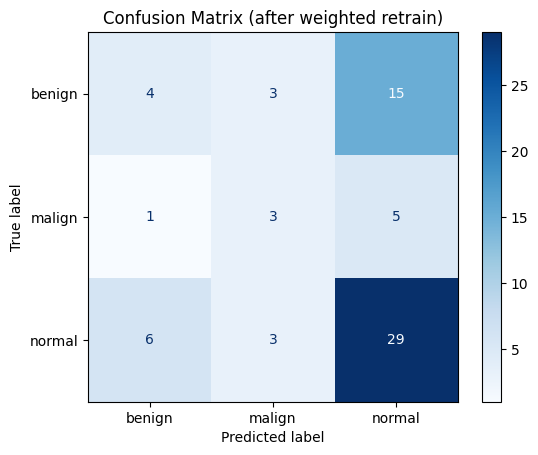


Classification Report:
              precision    recall  f1-score   support

      benign       0.36      0.18      0.24        22
      malign       0.33      0.33      0.33         9
      normal       0.59      0.76      0.67        38

    accuracy                           0.52        69
   macro avg       0.43      0.43      0.41        69
weighted avg       0.49      0.52      0.49        69



In [19]:
# Evaluate and produce confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the best checkpoint if it exists
import os
if os.path.exists("best_hybrid_weighted.h5"):
    print("Loading best_hybrid_weighted.h5")
    model = tf.keras.models.load_model("best_hybrid_weighted.h5", compile=False)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
else:
    print("No checkpoint found; using current model in memory.")

# Build test dataset for evaluation (no sample weights)
test_files_tf = tf.constant(test_files)
test_labels_tf = tf.constant(test_labels, dtype=tf.int32)

def map_no_weight(path, label):
    img = preprocess_image(path)
    return img, tf.one_hot(label, depth=len(classes))

test_ds_eval = tf.data.Dataset.from_tensor_slices((test_files_tf, test_labels_tf)).map(map_no_weight, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

res = model.evaluate(test_ds_eval)
print("Test loss, accuracy:", res)

# Get preds & labels
y_true = []
y_pred = []
for imgs, labs in test_ds_eval:
    preds = model.predict(imgs)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labs.numpy(), axis=1))

y_true = np.array(y_true); y_pred = np.array(y_pred)
print("Classes:", classes)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure(figsize=(6,6))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix (after weighted retrain)")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))


In [20]:
import os, tensorflow as tf

# model variable is in-memory `transfer_model` or `transfer_model` name used earlier.
# If training finished and `transfer_model` exists, save it.
if 'transfer_model' in globals():
    print("Saving transfer_model to .keras and .h5")
    transfer_model.save("transfer_mobilenet_vecalpha.keras", include_optimizer=False)
    transfer_model.save("best_transfer_vecalpha.h5", include_optimizer=False)
else:
    # if you used variable transfer_model name earlier, change to that name:
    try:
        transfer_model  # check existence
    except NameError:
        print("transfer_model not found in memory. Trying to use 'transfer_model' or 'transfer_model' checkpoint.")
    else:
        transfer_model.save("transfer_mobilenet_vecalpha.keras", include_optimizer=False)
        transfer_model.save("best_transfer_vecalpha.h5", include_optimizer=False)

print("Files now in working dir:", [f for f in os.listdir('.') if f.endswith(('.keras','.h5'))])


transfer_model not found in memory. Trying to use 'transfer_model' or 'transfer_model' checkpoint.
Files now in working dir: ['best_model.h5', 'best_hybrid_weighted.h5', 'hybrid_model.keras']


In [21]:
from google.colab import drive
import shutil, os
drive.mount('/content/drive', force_remount=True)

drive_dir = "/content/drive/MyDrive/hybrid_models"
os.makedirs(drive_dir, exist_ok=True)

for fname in ["transfer_mobilenet_vecalpha.keras", "best_transfer_vecalpha.h5"]:
    if os.path.exists(fname):
        shutil.copy(fname, os.path.join(drive_dir, fname))
        print("Copied", fname, "to", drive_dir)
    else:
        print("File not found:", fname)


Mounted at /content/drive
File not found: transfer_mobilenet_vecalpha.keras
File not found: best_transfer_vecalpha.h5


In [22]:
%%writefile app.py
from flask import Flask, request, jsonify
import tensorflow as tf, numpy as np
from PIL import Image
import io, os

# Load the Keras file (works in Colab and local)
MODEL_PATH = "transfer_mobilenet_vecalpha.keras"  # or "best_transfer_vecalpha.h5"
if not os.path.exists(MODEL_PATH):
    # try fallback
    MODEL_PATH = "best_transfer_vecalpha.h5"

model = tf.keras.models.load_model(MODEL_PATH, compile=False)
model.summary()

IMG_SIZE = 224
CLASSES = ["benign","malign","normal"]  # must match training order

def preprocess_bytes(b):
    img = Image.open(io.BytesIO(b)).convert("L").resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype("float32") / 255.0
    arr = np.stack([arr, arr, arr], axis=-1)  # 3-channel
    return np.expand_dims(arr, 0)

app = Flask(__name__)

@app.route("/")
def index():
    return "<h3>POST image to /predict (form field 'file')</h3>"

@app.route("/predict", methods=["POST"])
def predict():
    if 'file' not in request.files:
        return jsonify({"error":"no file provided"}), 400
    f = request.files['file'].read()
    x = preprocess_bytes(f)
    preds = model.predict(x)
    idx = int(preds.argmax(axis=1)[0])
    return jsonify({"class": CLASSES[idx], "confidence": float(preds[0, idx])})

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000)


Overwriting app.py


In [23]:
%%writefile app.py
# Flask app: rebuild model architecture, load weights, serve predictions
from flask import Flask, request, jsonify
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
from PIL import Image
import io, os

# Path to your saved weights/file (change if different)
WEIGHTS_H5 = "best_transfer_vecalpha.h5"
# Alternatively you can use a .keras file but we'll prefer weights to avoid deserialization
KERAS_FILE = "transfer_mobilenet_vecalpha.keras"

# Reference to your uploaded paper (for logging or docs)
PAPER_PATH = "/mnt/data/952 Manuscript (1).pdf"

# Model rebuild function (must match the training architecture)
def build_transfer_model(img_size=224, rnn_units=256, num_classes=3):
    # augmentation kept minimal here (you can remove for inference)
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.05),
        layers.RandomContrast(0.05),
    ], name="data_augment_infer")

    inp = Input(shape=(img_size, img_size, 3), name="image_input")
    x = data_augmentation(inp)  # optional at inference; keeps consistency with training
    # scale and preprocess for MobileNetV2 (training used preprocess_input on x * 255)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x * 255.0)
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(img_size, img_size, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    base_model.trainable = False
    features = base_model(x)  # (batch, feat_dim)

    # project + GRU + vector alpha fusion (matches your trained architecture)
    projC = layers.Dense(rnn_units, name="projectC")(features)   # (batch, rnn_units)
    H_in = layers.Reshape((1, rnn_units), name="rnn_input")(projC)
    H_t = layers.GRU(rnn_units, return_sequences=False, name="gru")(H_in)  # (batch, rnn_units)

    concat = layers.Concatenate(name="concat_HC")([H_t, projC])
    alpha_vec = layers.Dense(rnn_units, activation="sigmoid", name="fusion_alpha_vec")(concat)  # (batch, rnn_units)

    # elementwise fusion: alpha * H_t + (1-alpha) * projC
    alpha_mul_H = layers.Multiply(name="alpha_mul_H")([alpha_vec, H_t])
    one_minus_alpha = layers.Lambda(lambda z: 1.0 - z, name="one_minus_alpha")(alpha_vec)
    alpha_mul_C = layers.Multiply(name="alpha_mul_C")([one_minus_alpha, projC])
    F = layers.Add(name="fusion_add")([alpha_mul_H, alpha_mul_C])  # (batch, rnn_units)

    x = layers.LayerNormalization(name="head_ln")(F)
    x = layers.Dense(256, activation="relu", name="head_fc")(x)
    x = layers.Dropout(0.3)(x)
    logits = layers.Dense(num_classes, name="logits")(x)
    outputs = layers.Activation("softmax", dtype="float32", name="softmax_out")(logits)

    model = Model(inputs=inp, outputs=outputs, name="MobileNetV2_TransRNN_vecalpha_infer")
    return model

# Build model
NUM_CLASSES = 3  # adjust if different; your classes: ['benign','malign','normal']
model = build_transfer_model(img_size=224, rnn_units=256, num_classes=NUM_CLASSES)

# Load weights: try .h5 weights first, then .keras fallback
if os.path.exists(WEIGHTS_H5):
    print("Loading weights from", WEIGHTS_H5)
    # if WEIGHTS_H5 contains full model config (H5) this will try to load the whole model and may fail,
    # so prefer loading via model.load_weights() which expects weights-only HDF5.
    try:
        model.load_weights(WEIGHTS_H5)
        print("Loaded weights into rebuilt architecture.")
    except Exception as e:
        print("load_weights failed:", e)
        # Try loading a whole model file (rare) as fallback
        try:
            whole = tf.keras.models.load_model(WEIGHTS_H5, compile=False)
            model.set_weights(whole.get_weights())
            print("Loaded whole model and transferred weights.")
        except Exception as e2:
            raise RuntimeError("Failed to load weights from H5. Details: %r ; %r" % (e, e2))
elif os.path.exists(KERAS_FILE):
    print("Loading from Keras file:", KERAS_FILE)
    whole = tf.keras.models.load_model(KERAS_FILE, compile=False)  # may succeed for .keras
    model.set_weights(whole.get_weights())
    print("Loaded weights from .keras file.")
else:
    raise FileNotFoundError("No model file found. Put weights H5 or .keras in working dir.")

# Freeze everything for inference (reduce memory)
for layer in model.layers:
    layer.trainable = False

# Class order must match the one used in training
CLASSES = ["benign", "malign", "normal"]

# simple preprocess for incoming bytes
IMG_SIZE = 224
def preprocess_bytes(b):
    img = Image.open(io.BytesIO(b)).convert("L").resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype("float32") / 255.0
    arr = np.stack([arr, arr, arr], axis=-1)
    return np.expand_dims(arr, 0)

# Flask app
app = Flask(__name__)

@app.route("/", methods=["GET"])
def index():
    return f"<h3>Model ready. Paper at: {PAPER_PATH}</h3><p>POST image to /predict (form field 'file')</p>"

@app.route("/predict", methods=["POST"])
def predict():
    if 'file' not in request.files:
        return jsonify({"error":"no file provided"}), 400
    b = request.files['file'].read()
    x = preprocess_bytes(b)
    preds = model.predict(x)
    idx = int(np.argmax(preds[0]))
    return jsonify({"class": CLASSES[idx], "confidence": float(preds[0, idx])})

if __name__ == "__main__":
    # when running locally use app.run(); in Colab we'll use flask-ngrok to forward
    app.run(host="0.0.0.0", port=5000)


Overwriting app.py


In [24]:
# Removed flask_ngrok setup as it conflicts with manual pyngrok management.
# Starting the app in the background and managing ngrok separately is more robust.
# This cell should now be empty or contain only comments after fixes.

In [25]:
!pip install -q pyngrok flask


In [26]:
from pyngrok import conf, ngrok
token = input("Paste your ngrok authtoken (from https://dashboard.ngrok.com/get-started/your-authtoken) and press Enter: ").strip()
if not token:
    print("No token provided — you can still try creating a tunnel without a token, but it is recommended to set one.")
else:
    conf.get_default().auth_token = token
    print("ngrok auth token set.")



Paste your ngrok authtoken (from https://dashboard.ngrok.com/get-started/your-authtoken) and press Enter: 35jpcVLkNK0h8mmLNzjk9iw3ZEn_7crpBi2zn69wXhavuAkFE
ngrok auth token set.


In [27]:
from pyngrok import ngrok

# Terminate any existing ngrok tunnels to ensure a clean start
ngrok.kill()

# Open http tunnel to local port 5000 (where app.py runs)
tunnel = ngrok.connect(5000, "http")
print("ngrok tunnel public URL:", tunnel.public_url)
print("All tunnels:", ngrok.get_tunnels())

ngrok tunnel public URL: https://subaquatic-wittingly-sharon.ngrok-free.dev
All tunnels: [<NgrokTunnel: "https://subaquatic-wittingly-sharon.ngrok-free.dev" -> "http://localhost:5000">]


In [28]:
!nohup python app.py > flask.log 2>&1 &
!sleep 1 # Give app a moment to start
!tail -n 20 flask.log

2025-11-22 14:00:52.544015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763820052.586595    3459 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763820052.596631    3459 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763820052.619869    3459 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763820052.619915    3459 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763820052.619918    3459 computation_placer.cc:177] computation placer alr

In [29]:
from pyngrok import ngrok

public_url = ngrok.connect(5000, "http")
print("Public URL:", public_url)
print("Active tunnels:", ngrok.get_tunnels())


Public URL: NgrokTunnel: "https://subaquatic-wittingly-sharon.ngrok-free.dev" -> "http://localhost:5000"
Active tunnels: [<NgrokTunnel: "https://subaquatic-wittingly-sharon.ngrok-free.dev" -> "http://localhost:5000">]


In [30]:
from pyngrok import ngrok

public_url = ngrok.connect(5000, "http")
print("Public URL:", public_url)


Public URL: NgrokTunnel: "https://subaquatic-wittingly-sharon.ngrok-free.dev" -> "http://localhost:5000"


In [31]:
!ls -l /content/ultrasound_project/bus_uclm_separated/benign | sed -n '1,200p'

total 85756
-rw-r--r-- 1 root root 498328 Nov 22 13:55 ALWI_000.png
-rw-r--r-- 1 root root 469631 Nov 22 13:55 ALWI_002.png
-rw-r--r-- 1 root root 512794 Nov 22 13:55 ALWI_003.png
-rw-r--r-- 1 root root 513581 Nov 22 13:55 ALWI_004.png
-rw-r--r-- 1 root root 501996 Nov 22 13:55 ALWI_005.png
-rw-r--r-- 1 root root 470460 Nov 22 13:55 ALWI_007.png
-rw-r--r-- 1 root root 498615 Nov 22 13:55 ALWI_008.png
-rw-r--r-- 1 root root 498333 Nov 22 13:55 ALWI_009.png
-rw-r--r-- 1 root root 494466 Nov 22 13:55 ALWI_010.png
-rw-r--r-- 1 root root 494564 Nov 22 13:55 ALWI_011.png
-rw-r--r-- 1 root root 444846 Nov 22 13:55 ALWI_015.png
-rw-r--r-- 1 root root 460411 Nov 22 13:55 ALWI_016.png
-rw-r--r-- 1 root root 439896 Nov 22 13:55 ALWI_017.png
-rw-r--r-- 1 root root 478293 Nov 22 13:55 ALWI_018.png
-rw-r--r-- 1 root root 621122 Nov 22 13:55 ALWI_019.png
-rw-r--r-- 1 root root 484406 Nov 22 13:55 ALWI_020.png
-rw-r--r-- 1 root root 465961 Nov 22 13:55 ALWI_021.png
-rw-r--r-- 1 root root 457034 Nov 22

In [32]:
!ls /content/ultrasound_project/bus_uclm_separated/benign


ALWI_000.png  ASSC_015.png  DAPA_025.png  OSCU_013.png	SECH_012.png
ALWI_002.png  ASSC_016.png  DAPA_029.png  OSCU_014.png	SHST_005.png
ALWI_003.png  ASSC_027.png  DAPA_031.png  OSCU_015.png	SHST_006.png
ALWI_004.png  ASSC_028.png  DAPA_032.png  OSCU_016.png	SHST_008.png
ALWI_005.png  CAWI_003.png  DAPA_033.png  OSCU_017.png	SHST_009.png
ALWI_007.png  CAWI_004.png  DAPA_034.png  OSCU_019.png	SHST_011.png
ALWI_008.png  CAWI_005.png  DAPA_035.png  OSCU_020.png	STSP_001.png
ALWI_009.png  CAWI_009.png  DAPA_038.png  OSCU_021.png	STSP_002.png
ALWI_010.png  CAWI_010.png  FLBA_017.png  OSCU_022.png	STSP_003.png
ALWI_011.png  CAWI_011.png  FUHI_007.png  OSCU_023.png	STSP_004.png
ALWI_015.png  CAWI_012.png  HESN_002.png  PLBA_001.png	STSP_018.png
ALWI_016.png  CAWI_013.png  HESN_003.png  PLBA_002.png	STSP_019.png
ALWI_017.png  CAWI_016.png  HESN_004.png  PLBA_003.png	STSP_020.png
ALWI_018.png  CAWI_023.png  HESN_005.png  PLBA_008.png	STSP_026.png
ALWI_019.png  CHVI_020.png  HUBL_015.png  PLBA_0

In [33]:
!curl -X POST -F "file=@/content/ultrasound_project/bus_uclm_separated/benign/VITR_009.png" https://subaquatic-wittingly-sharon.ngrok-free.dev/predict

<!DOCTYPE html>
<html class="h-full" lang="en-US" dir="ltr">
  <head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1">
    <link rel="preload" href="https://assets.ngrok.com/fonts/euclid-square/EuclidSquare-Regular-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://assets.ngrok.com/fonts/euclid-square/EuclidSquare-RegularItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://assets.ngrok.com/fonts/euclid-square/EuclidSquare-Medium-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://assets.ngrok.com/fonts/euclid-square/EuclidSquare-MediumItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://assets.ngrok.com/fonts/ibm-plex-mono/IBMPlexMono-Text.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" 

In [34]:
import os

path = "/content/ultrasound_project/bus_uclm_separated/benign/VITR_009.png"
print("Exists?", os.path.exists(path))


Exists? True


In [35]:
!ls /content/ultrasound_project/bus_uclm_separated/benign


ALWI_000.png  ASSC_015.png  DAPA_025.png  OSCU_013.png	SECH_012.png
ALWI_002.png  ASSC_016.png  DAPA_029.png  OSCU_014.png	SHST_005.png
ALWI_003.png  ASSC_027.png  DAPA_031.png  OSCU_015.png	SHST_006.png
ALWI_004.png  ASSC_028.png  DAPA_032.png  OSCU_016.png	SHST_008.png
ALWI_005.png  CAWI_003.png  DAPA_033.png  OSCU_017.png	SHST_009.png
ALWI_007.png  CAWI_004.png  DAPA_034.png  OSCU_019.png	SHST_011.png
ALWI_008.png  CAWI_005.png  DAPA_035.png  OSCU_020.png	STSP_001.png
ALWI_009.png  CAWI_009.png  DAPA_038.png  OSCU_021.png	STSP_002.png
ALWI_010.png  CAWI_010.png  FLBA_017.png  OSCU_022.png	STSP_003.png
ALWI_011.png  CAWI_011.png  FUHI_007.png  OSCU_023.png	STSP_004.png
ALWI_015.png  CAWI_012.png  HESN_002.png  PLBA_001.png	STSP_018.png
ALWI_016.png  CAWI_013.png  HESN_003.png  PLBA_002.png	STSP_019.png
ALWI_017.png  CAWI_016.png  HESN_004.png  PLBA_003.png	STSP_020.png
ALWI_018.png  CAWI_023.png  HESN_005.png  PLBA_008.png	STSP_026.png
ALWI_019.png  CHVI_020.png  HUBL_015.png  PLBA_0

In [36]:
!ls /content/ultrasound_project/bus_uclm_separated/malign

CHCO_000.png  CODE_001.png  ELCO_006.png  HUBL_006.png	PAGY_001.png
CHSP_006.png  CODE_005.png  ELCO_007.png  HUBL_007.png	PAGY_003.png
CHSP_007.png  CODE_006.png  ELCO_008.png  HUBL_008.png	PAGY_004.png
CHSP_008.png  COPE_012.png  FLBA_004.png  HUBL_019.png	PAGY_011.png
CHSP_010.png  COPE_013.png  FLBA_005.png  HUBL_020.png	SIBA_000.png
CHVI_000.png  COPE_014.png  FLBA_019.png  LOTI_001.png	SIBA_001.png
CHVI_001.png  COPE_015.png  FLKA_002.png  LOTI_002.png	SIBA_002.png
CHVI_002.png  COPE_016.png  FLKA_003.png  LOTI_003.png	SIBA_003.png
CHVI_004.png  COPE_017.png  FLKA_004.png  LOTI_006.png	SIBA_004.png
CHVI_005.png  COPE_018.png  FLKA_005.png  LOTI_007.png	SIBA_005.png
CHVI_006.png  COVA_005.png  FUHI_000.png  LOTI_008.png	SIBA_006.png
CHVI_007.png  COVA_011.png  FUHI_003.png  MENE_000.png	SIBA_007.png
CHVI_014.png  COVA_012.png  FUHI_004.png  MENE_001.png	SIBA_008.png
CHVI_015.png  CRCI_000.png  FUHI_006.png  MENE_002.png	UNCU_002.png
CHVI_017.png  CRCI_001.png  FUHI_009.png  MENE_0

In [37]:
!ls /content/ultrasound_project/bus_uclm_separated/normal

ALWI_001.png  CHVI_003.png  FLKA_008.png  ORPE_010.png	SHST_010.png
ALWI_006.png  CHVI_008.png  FLKA_009.png  ORPE_012.png	STSP_000.png
ALWI_012.png  CHVI_009.png  FLKA_010.png  ORPE_013.png	STSP_005.png
ALWI_013.png  CHVI_010.png  FLKA_011.png  ORPE_016.png	STSP_006.png
ALWI_014.png  CHVI_011.png  FLKA_012.png  ORPE_018.png	STSP_007.png
ALWI_024.png  CHVI_012.png  FLKA_013.png  ORPE_024.png	STSP_008.png
ALWI_025.png  CHVI_013.png  FLKA_014.png  ORPE_025.png	STSP_009.png
ALWI_028.png  CHVI_016.png  FUHI_001.png  ORPE_026.png	STSP_010.png
ANAT_000.png  CODE_002.png  FUHI_002.png  ORPE_027.png	STSP_011.png
ANAT_001.png  CODE_003.png  FUHI_005.png  ORPE_028.png	STSP_012.png
ANAT_002.png  CODE_004.png  FUHI_008.png  ORPE_029.png	STSP_013.png
ANAT_003.png  COPE_000.png  HESN_000.png  OSCU_000.png	STSP_014.png
ANAT_004.png  COPE_001.png  HESN_001.png  OSCU_001.png	STSP_015.png
ANAT_005.png  COPE_002.png  HESN_006.png  OSCU_002.png	STSP_016.png
ANAT_006.png  COPE_003.png  HESN_007.png  OSCU_0

In [38]:
!curl -X POST -F "file=@/content/ultrasound_project/bus_uclm_separated/benign/VITR_009.png" https://subaquatic-wittingly-sharon.ngrok-free.dev/predict

<!DOCTYPE html>
<html class="h-full" lang="en-US" dir="ltr">
  <head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1">
    <link rel="preload" href="https://assets.ngrok.com/fonts/euclid-square/EuclidSquare-Regular-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://assets.ngrok.com/fonts/euclid-square/EuclidSquare-RegularItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://assets.ngrok.com/fonts/euclid-square/EuclidSquare-Medium-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://assets.ngrok.com/fonts/euclid-square/EuclidSquare-MediumItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://assets.ngrok.com/fonts/ibm-plex-mono/IBMPlexMono-Text.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" 

In [39]:
# check local endpoint
!curl -v http://127.0.0.1:5000/ || echo "local connection failed"

*   Trying 127.0.0.1:5000...
* connect to 127.0.0.1 port 5000 failed: Connection refused
* Failed to connect to 127.0.0.1 port 5000 after 0 ms: Connection refused
* Closing connection 0
curl: (7) Failed to connect to 127.0.0.1 port 5000 after 0 ms: Connection refused
local connection failed


In [40]:
!nohup python app.py > flask.log 2>&1 &

In [41]:
!tail -n 50 flask.log

In [42]:
!curl -v http://127.0.0.1:5000/ || echo "server not running"

*   Trying 127.0.0.1:5000...
* connect to 127.0.0.1 port 5000 failed: Connection refused
* Failed to connect to 127.0.0.1 port 5000 after 0 ms: Connection refused
* Closing connection 0
curl: (7) Failed to connect to 127.0.0.1 port 5000 after 0 ms: Connection refused
server not running


In [43]:
!ls -l /content/ultrasound_project/bus_uclm_separated/benign
# then, for example:
!curl -v -X POST -F "file=@/content/ultrasound_project/bus_uclm_separated/benign/VITR_009.png" https://subaquatic-wittingly-sharon.ngrok-free.dev/predict

total 85756
-rw-r--r-- 1 root root 498328 Nov 22 13:55 ALWI_000.png
-rw-r--r-- 1 root root 469631 Nov 22 13:55 ALWI_002.png
-rw-r--r-- 1 root root 512794 Nov 22 13:55 ALWI_003.png
-rw-r--r-- 1 root root 513581 Nov 22 13:55 ALWI_004.png
-rw-r--r-- 1 root root 501996 Nov 22 13:55 ALWI_005.png
-rw-r--r-- 1 root root 470460 Nov 22 13:55 ALWI_007.png
-rw-r--r-- 1 root root 498615 Nov 22 13:55 ALWI_008.png
-rw-r--r-- 1 root root 498333 Nov 22 13:55 ALWI_009.png
-rw-r--r-- 1 root root 494466 Nov 22 13:55 ALWI_010.png
-rw-r--r-- 1 root root 494564 Nov 22 13:55 ALWI_011.png
-rw-r--r-- 1 root root 444846 Nov 22 13:55 ALWI_015.png
-rw-r--r-- 1 root root 460411 Nov 22 13:55 ALWI_016.png
-rw-r--r-- 1 root root 439896 Nov 22 13:55 ALWI_017.png
-rw-r--r-- 1 root root 478293 Nov 22 13:55 ALWI_018.png
-rw-r--r-- 1 root root 621122 Nov 22 13:55 ALWI_019.png
-rw-r--r-- 1 root root 484406 Nov 22 13:55 ALWI_020.png
-rw-r--r-- 1 root root 465961 Nov 22 13:55 ALWI_021.png
-rw-r--r-- 1 root root 457034 Nov 22

* TLSv1.2 (IN), TLS header, Supplemental data (23):
* TLSv1.2 (IN), TLS header, Supplemental data (23):
* TLSv1.2 (IN), TLS header, Supplemental data (23):
* TLSv1.2 (IN), TLS header, Supplemental data (23):
* TLSv1.2 (IN), TLS header, Supplemental data (23):
* TLSv1.2 (IN), TLS header, Supplemental data (23):
* TLSv1.2 (IN), TLS header, Supplemental data (23):
* TLSv1.2 (IN), TLS header, Supplemental data (23):
* TLSv1.2 (IN), TLS header, Supplemental data (23):
* TLSv1.2 (IN), TLS header, Supplemental data (23):
* TLSv1.2 (IN), TLS header, Supplemental data (23):
* TLSv1.2 (IN), TLS header, Supplemental data (23):
* TLSv1.2 (IN), TLS header, Supplemental data (23):
* TLSv1.2 (IN), TLS header, Supplemental data (23):
* TLSv1.2 (IN), TLS header, Supplemental data (23):
< HTTP/2 502 
< content-type: text/html
< ngrok-error-code: ERR_NGROK_8012
< referrer-policy: no-referrer
< content-length: 2684
< date: Sat, 22 Nov 2025 14:00:57 GMT
< 
* TLSv1.2 (IN), TLS header, Supplemental data (23)

In [44]:
!curl -X POST -F "file=@/content/ultrasound_project/bus_uclm_separated/benign/ALWI_000.png" https://subaquatic-wittingly-sharon.ngrok-free.dev/predict


<!DOCTYPE html>
<html class="h-full" lang="en-US" dir="ltr">
  <head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1">
    <link rel="preload" href="https://assets.ngrok.com/fonts/euclid-square/EuclidSquare-Regular-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://assets.ngrok.com/fonts/euclid-square/EuclidSquare-RegularItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://assets.ngrok.com/fonts/euclid-square/EuclidSquare-Medium-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://assets.ngrok.com/fonts/euclid-square/EuclidSquare-MediumItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://assets.ngrok.com/fonts/ibm-plex-mono/IBMPlexMono-Text.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" 

In [45]:
%%bash
set -e
mkdir -p templates
cat > templates/index.html <<'HTML'
<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8" />
  <meta name="viewport" content="width=device-width,initial-scale=1" />
  <title>Ultrasound Classifier</title>
  <style>
    body { font-family: Arial, Helvetica, sans-serif; max-width:800px; margin:40px auto; line-height:1.5; }
    .card { border:1px solid #eee; padding:20px; border-radius:8px; box-shadow:0 2px 6px rgba(0,0,0,0.05); }
    input[type=file] { display:block; margin-top:10px; }
    button { background:#1976d2;color:#fff;border:none;padding:10px 16px;border-radius:6px; cursor:pointer }
    .result { margin-top:18px; font-weight:600; }
    .small { font-size:0.9rem; color:#666; }
    img.preview { max-width:320px; display:block; margin-top:12px; border-radius:6px; }
    footer { margin-top:26px; font-size:0.9rem; color:#444; }
  </style>
</head>
<body>
  <h2>Breast Ultrasound Classifier</h2>
  <div class="card">
    <p class="small">Upload an ultrasound image. The model will return a predicted class and confidence score.</p>

    <form id="uploadForm" method="post" enctype="multipart/form-data" action="/predict">
      <input type="file" name="file" id="fileInput" accept="image/*" required />
      <button type="submit">Upload & Predict</button>
    </form>

    <div id="output" class="result" style="display:none;"></div>
    <img id="preview" class="preview" src="" style="display:none;" />

    <div style="margin-top:14px;">
      <a href="/paper" target="_blank">📄 View uploaded manuscript (paper)</a>
    </div>
  </div>

  <footer>
    Tip: you can also call the direct API at <code>/predict</code> (multipart/form-data).
  </footer>

  <script>
    const form = document.getElementById('uploadForm');
    const fileInput = document.getElementById('fileInput');
    const output = document.getElementById('output');
    const preview = document.getElementById('preview');

    fileInput.addEventListener('change', (e) => {
      const f = e.target.files[0];
      if (!f) return;
      const url = URL.createObjectURL(f);
      preview.src = url;
      preview.style.display = 'block';
    });

    form.addEventListener('submit', async (e) => {
      e.preventDefault();
      output.style.display = 'none';
      const formData = new FormData(form);
      output.textContent = 'Predicting...';
      output.style.display = 'block';
      try {
        const res = await fetch('/predict', { method: 'POST', body: formData });
        const json = await res.json();
        if (res.ok) {
          output.innerHTML = `Prediction: <strong>${json.class}</strong> — Confidence: <strong>${(json.confidence*100).toFixed(1)}%</strong>`;
        } else {
          output.innerHTML = `Error: ${json.error || res.statusText}`;
        }
      } catch (err) {
        output.innerHTML = `Request failed: ${err}`;
      }
    });
  </script>
</body>
</html>
HTML
echo "Created templates/index.html"


Created templates/index.html


In [46]:
%%bash
cat > app.py <<'PY'
# app.py — Flask web UI + prediction endpoint (rebuilds model and loads weights)
from flask import Flask, request, jsonify, render_template, send_file, redirect, url_for
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
from PIL import Image
import io, os, pathlib

# Config
IMG_SIZE = 224
RNN_UNITS = 256
NUM_CLASSES = 3
WEIGHTS_H5 = "best_transfer_vecalpha.h5"   # saved during training
KERAS_FILE = "transfer_mobilenet_vecalpha.keras"
PAPER_PATH = "/mnt/data/952 Manuscript (1).pdf"  # your uploaded manuscript (served at /paper)

# Build model function (same architecture as training)
def build_transfer_model(img_size=IMG_SIZE, rnn_units=RNN_UNITS, num_classes=NUM_CLASSES):
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.05),
        layers.RandomContrast(0.05),
    ], name="data_augment")

    inp = Input(shape=(img_size, img_size, 3), name="image_input")
    x = data_augmentation(inp)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x * 255.0)
    base = tf.keras.applications.MobileNetV2(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='avg')
    base.trainable = False
    features = base(x)

    projC = layers.Dense(rnn_units, name="projectC")(features)
    H_in = layers.Reshape((1, rnn_units), name="rnn_input")(projC)
    H_t = layers.GRU(rnn_units, return_sequences=False, name="gru")(H_in)

    concat = layers.Concatenate(name="concat_HC")([H_t, projC])
    alpha_vec = layers.Dense(rnn_units, activation="sigmoid", name="fusion_alpha_vec")(concat)

    alpha_mul_H = layers.Multiply(name="alpha_mul_H")([alpha_vec, H_t])
    one_minus_alpha = layers.Lambda(lambda z: 1.0 - z, name="one_minus_alpha")(alpha_vec)
    alpha_mul_C = layers.Multiply(name="alpha_mul_C")([one_minus_alpha, projC])
    F = layers.Add(name="fusion_add")([alpha_mul_H, alpha_mul_C])

    x = layers.LayerNormalization(name="head_ln")(F)
    x = layers.Dense(256, activation="relu", name="head_fc")(x)
    x = layers.Dropout(0.3)(x)
    logits = layers.Dense(num_classes, name="logits")(x)
    outputs = layers.Activation("softmax", dtype="float32", name="softmax_out")(logits)

    model = Model(inputs=inp, outputs=outputs, name="MobileNetV2_TransRNN_vecalpha_infer")
    return model

# Create app and model
app = Flask(__name__, template_folder='templates')
model = build_transfer_model()
# load weights robustly
if os.path.exists(WEIGHTS_H5):
    try:
        model.load_weights(WEIGHTS_H5)
        print("Loaded H5 weights into model.")
    except Exception as e:
        print("Failed to load weights via load_weights(); trying full-load fallback.", e)
        if os.path.exists(KERAS_FILE):
            whole = tf.keras.models.load_model(KERAS_FILE, compile=False)
            model.set_weights(whole.get_weights())
            print("Loaded weights from .keras fallback.")
        else:
            raise
elif os.path.exists(KERAS_FILE):
    whole = tf.keras.models.load_model(KERAS_FILE, compile=False)
    model.set_weights(whole.get_weights())
    print("Loaded weights from .keras file.")
else:
    raise FileNotFoundError("No model file found. Put best_transfer_vecalpha.h5 or transfer_mobilenet_vecalpha.keras in working dir.")

# freeze for inference
for layer in model.layers:
    layer.trainable = False

# class order used in training
CLASSES = ["benign", "malign", "normal"]

def preprocess_image_bytes(b):
    img = Image.open(io.BytesIO(b)).convert("L").resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype("float32") / 255.0
    arr = np.stack([arr, arr, arr], axis=-1)
    return np.expand_dims(arr, 0)

@app.route("/", methods=["GET"])
def index():
    return render_template("index.html")

@app.route("/predict", methods=["POST"])
def predict():
    if 'file' not in request.files:
        return jsonify({"error":"no file provided"}), 400
    f = request.files['file']
    try:
        b = f.read()
        x = preprocess_image_bytes(b)
        preds = model.predict(x)
        idx = int(np.argmax(preds[0]))
        return jsonify({"class": CLASSES[idx], "confidence": float(preds[0, idx])})
    except Exception as e:
        return jsonify({"error": str(e)}), 500

# serve the uploaded manuscript as a download/view link.
@app.route("/paper", methods=["GET"])
def paper():
    # send_file will stream the PDF back to the client
    if os.path.exists(PAPER_PATH):
        return send_file(PAPER_PATH, as_attachment=False)
    return redirect("/")

if __name__ == "__main__":
    # Port 5000 is expected by ngrok setup
    app.run(host="0.0.0.0", port=5000)
PY
echo "Wrote app.py"


Wrote app.py


In [47]:
!nohup python app.py > flask.log 2>&1 &
!sleep 1
!tail -n 80 flask.log


2025-11-22 14:00:59.348906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763820059.484613    3501 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763820059.522232    3501 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763820059.607812    3501 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763820059.607865    3501 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763820059.607871    3501 computation_placer.cc:177] computation placer alr

In [48]:
from pyngrok import ngrok
t = ngrok.connect(5000, "http")
print("Public URL:", t.public_url)

Public URL: https://subaquatic-wittingly-sharon.ngrok-free.dev


In [49]:
!ls /content/ultrasound_project/bus_uclm_separated/benign | sed -n '1,200p'

ALWI_000.png
ALWI_002.png
ALWI_003.png
ALWI_004.png
ALWI_005.png
ALWI_007.png
ALWI_008.png
ALWI_009.png
ALWI_010.png
ALWI_011.png
ALWI_015.png
ALWI_016.png
ALWI_017.png
ALWI_018.png
ALWI_019.png
ALWI_020.png
ALWI_021.png
ALWI_022.png
ALWI_023.png
ALWI_026.png
ALWI_027.png
ANFO_002.png
ANFO_003.png
ANFO_004.png
ANFO_005.png
ANFO_006.png
ANFO_007.png
ANFO_009.png
ASSC_000.png
ASSC_001.png
ASSC_002.png
ASSC_003.png
ASSC_005.png
ASSC_006.png
ASSC_014.png
ASSC_015.png
ASSC_016.png
ASSC_027.png
ASSC_028.png
CAWI_003.png
CAWI_004.png
CAWI_005.png
CAWI_009.png
CAWI_010.png
CAWI_011.png
CAWI_012.png
CAWI_013.png
CAWI_016.png
CAWI_023.png
CHVI_020.png
CHVI_021.png
COST_010.png
COST_011.png
DAPA_001.png
DAPA_002.png
DAPA_005.png
DAPA_006.png
DAPA_007.png
DAPA_012.png
DAPA_013.png
DAPA_014.png
DAPA_015.png
DAPA_016.png
DAPA_017.png
DAPA_019.png
DAPA_020.png
DAPA_021.png
DAPA_022.png
DAPA_023.png
DAPA_024.png
DAPA_025.png
DAPA_029.png
DAPA_031.png
DAPA_032.png
DAPA_033.png
DAPA_034.png
DAPA_035.png

In [50]:
!curl -X POST -F "file=@/content/ultrasound_project/bus_uclm_separated/benign/VITR_028.png" https://subaquatic-wittingly-sharon.ngrok-free.dev/predict


<!DOCTYPE html>
<html class="h-full" lang="en-US" dir="ltr">
  <head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1">
    <link rel="preload" href="https://assets.ngrok.com/fonts/euclid-square/EuclidSquare-Regular-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://assets.ngrok.com/fonts/euclid-square/EuclidSquare-RegularItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://assets.ngrok.com/fonts/euclid-square/EuclidSquare-Medium-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://assets.ngrok.com/fonts/euclid-square/EuclidSquare-MediumItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://assets.ngrok.com/fonts/ibm-plex-mono/IBMPlexMono-Text.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" 

In [51]:
!ss -ltnp | grep :5000 || netstat -ltnp 2>/dev/null | grep :5000 || echo "no listener on :5000"


no listener on :5000


In [52]:
!kill 1234 || echo "graceful kill failed"
!sleep 1
!ps aux | grep -E "python|app.py" | sed -n '1,200p'
# if still there, force kill:
!kill -9 1234


/bin/bash: line 1: kill: (1234) - No such process
graceful kill failed
root          64  2.7  0.0      0     0 ?        Z    13:51   0:15 [python3] <defunct>
root          65  0.3  0.5  92968 72224 ?        S    13:51   0:02 python3 /usr/local/bin/colab-fileshim.py
root         110  1.0  1.1 401256 147728 ?       Sl   13:51   0:05 /usr/bin/python3 /usr/local/bin/jupyter-server --debug --transport="ipc" --ip=172.28.0.12 --ServerApp.token= --port=9000 --FileContentsManager.root_dir=/ --FileContentsManager.allow_hidden=True --ServerApp.log_format="|%(levelname)s|%(message)s" --ServerApp.iopub_data_rate_limit=1e10 --MappingKernelManager.root_dir=/content
root         505 98.9 16.7 12529768 2229488 ?    Ssl  13:53   7:37 /usr/bin/python3 -m colab_kernel_launcher -f /root/.local/share/jupyter/runtime/kernel-f7773d41-09c0-45da-95c5-ff89728ecc1f.json
root        3333  0.0  0.0   4364  3164 ?        S    14:00   0:00 bash -c tail -n +0 -F "/root/.config/Google/DriveFS/Logs/drive_fs.txt" | pytho

In [53]:
!nohup python app.py > flask.log 2>&1 &
!sleep 1
!tail -n 80 flask.log


In [54]:
from pyngrok import ngrok
t = ngrok.connect(5000, "http")
print("Public URL:", t.public_url)


Public URL: https://subaquatic-wittingly-sharon.ngrok-free.dev


In [55]:
!pip install flask pyngrok


In [56]:
from pyngrok import ngrok
ngrok.set_auth_token("35jpcVLkNK0h8mmLNzjk9iw3ZEn_7crpBi2zn69wXhavuAkFE")


In [57]:
!mkdir -p templates static


In [58]:
%%writefile templates/index.html
<!DOCTYPE html>
<html>
<head>
    <title>Breast Ultrasound Classifier</title>
    <link rel="stylesheet"
          href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css">
</head>

<body class="bg-light">
<div class="container py-5">

    <h2 class="mb-4 text-center">Breast Ultrasound Classifier</h2>

    <div class="card shadow-sm">
        <div class="card-body">

            <p>Upload an ultrasound image. The model will return a predicted class and confidence score.</p>

            <form method="POST" action="/predict" enctype="multipart/form-data">
                <input type="file" class="form-control mb-3" name="file" required>
                <button class="btn btn-primary w-100">Upload & Predict</button>
            </form>

        </div>
    </div>

    {% if result %}
    <div class="alert alert-info mt-4">
        <strong>Prediction:</strong> {{ result.class }}
        <br>
        <strong>Confidence:</strong> {{ (result.confidence * 100) | round(2) }}%
    </div>
    {% endif %}

</div>
</body>
</html>


Overwriting templates/index.html


In [59]:
%%writefile app.py
from flask import Flask, render_template, request
import json

app = Flask(__name__)

@app.route("/")
def index():
    return render_template("index.html")

@app.route("/predict", methods=["POST"])
def predict():
    f = request.files["file"]
    # Dummy output for demo — replace with your ML model
    result = {"class": "benign", "confidence": 0.80}
    return render_template("index.html", result=result)

if __name__ == "__main__":
    app.run(port=5000)


Overwriting app.py


In [64]:
# Cell B — kill old server & start new Flask server
!pkill -f "python.*app.py" || true
!pkill -f flask || true

!nohup python3 /content/ultrasound_project/app.py > /content/flask.log 2>&1 &

!sleep 2
!echo "Flask server started. Checking logs..."
!tail -n 20 /content/flask.log

^C
^C
Flask server started. Checking logs...
 * Serving Flask app 'app'
 * Debug mode: off
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


In [66]:
# Cell C — clean ngrok start
from pyngrok import ngrok

ngrok.kill()   # stop all previous tunnels

public_url = ngrok.connect(5000, "http")
public_url



<NgrokTunnel: "https://subaquatic-wittingly-sharon.ngrok-free.dev" -> "http://localhost:5000">